# Californian Housing Market




In Sklearn, there are datasets that are already pre-recorded that we can use for our purposes to apply Machine Learning algorithms. Let's try to look at the first one with Californian Housing Market.

1. Import the usual librairies

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
#pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

## The dataset

2. Use the following lines of code to retrieve California real estate price data:

In [2]:
from sklearn import datasets
data = datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False)
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

3. Explore the target values and get the names of the different explanatory variables.

💡 The (documentation)[https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing] may help you 😉

In [3]:
print("target values:")
data['target']

target values:


array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [4]:
print("feature names:")
data["feature_names"]

feature names:


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

4. We'd prefer to have this data in a DataFrame. Use the Pandas library to find a way to put this data into a DataFrame. 

You can go more specifically look at the following link: 

[DataFrame in Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [5]:
dataset = pd.DataFrame(columns=data["feature_names"], data=data["data"])
dataset.loc[:,'Price'] = data["target"]
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## EDA

5. Make a bivariate plot of each pair of variables, and analyze the relationship of each variable with the target (_Price_)

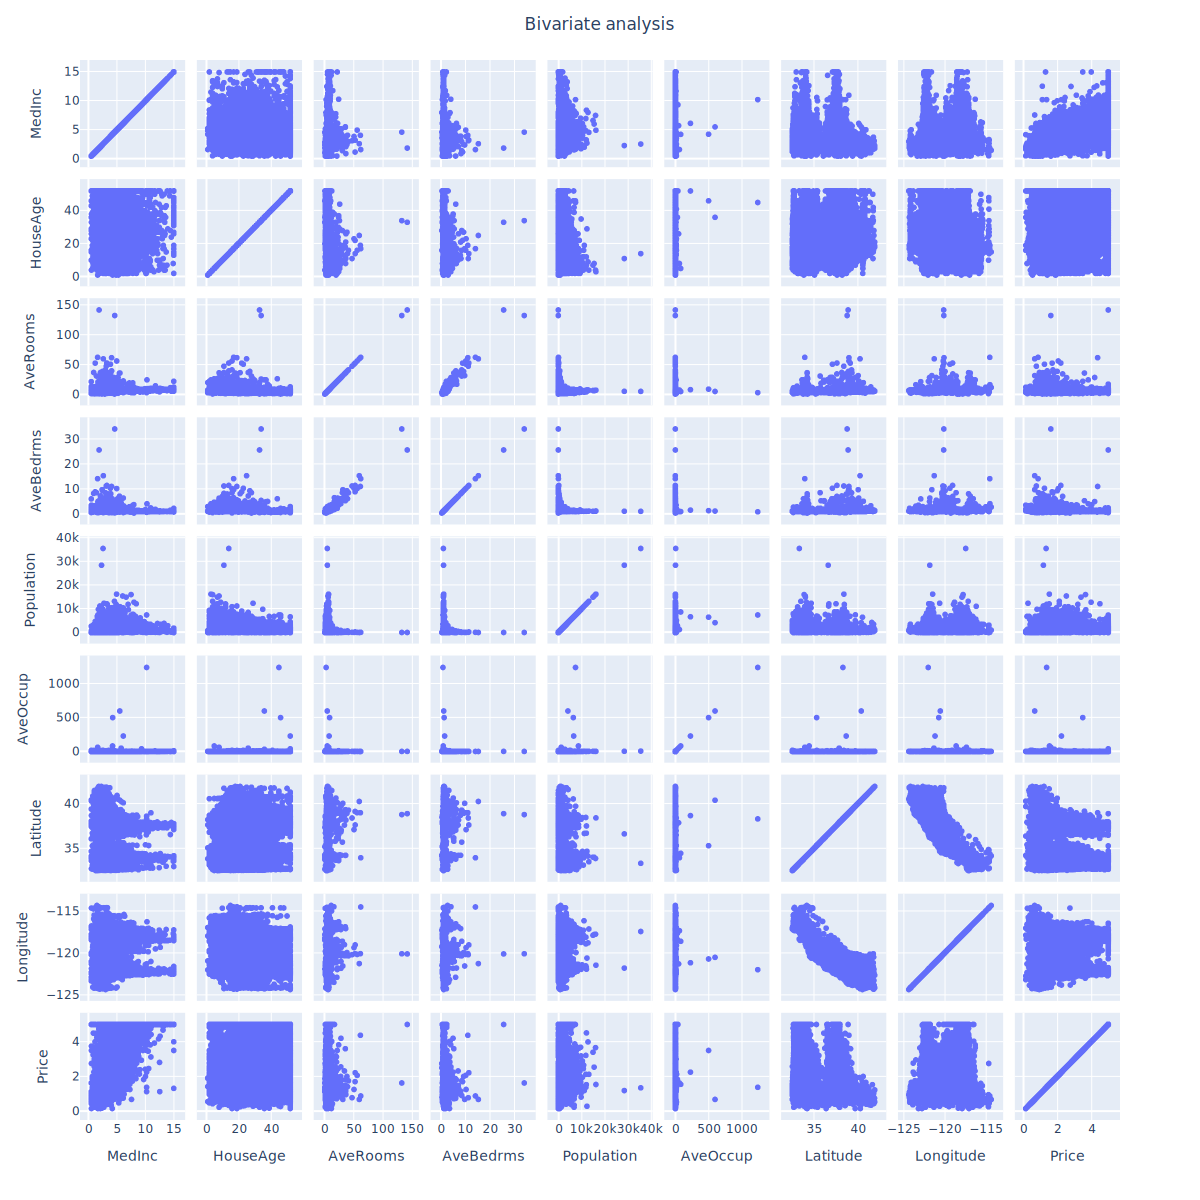

In [6]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(dataset)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

6. There seem to be some correlations between some features and the target, but the plot are a bit deteriorated by the presence of outliers. Let's filter out these outliers:
* Create a mask that allows to keep lines with : _AveRooms_ < 10 ; _AveBedRooms_ < 10 ; _Population_ < 15000 ; _AveOccup_ < 10 and _Price_ < 5
* Use this mask to filter out the outliers from your dataset and make a new bivariate plot
* Do you see anyting interesting ?

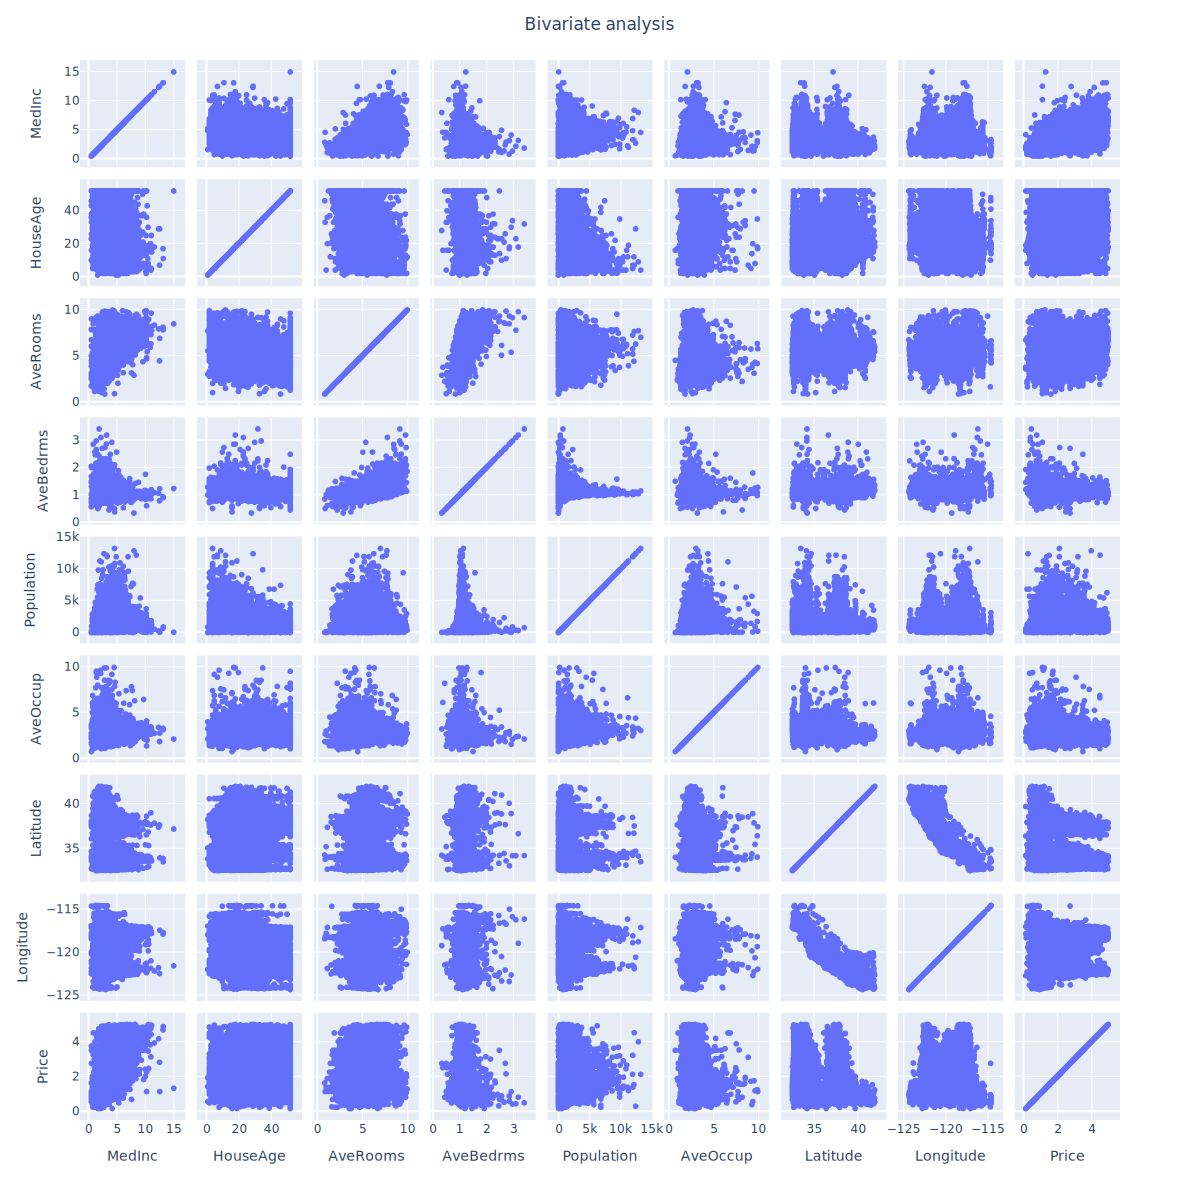

In [7]:
mask = (dataset['AveRooms'] < 10) & (dataset['AveBedrms'] < 10) & (dataset['Population'] < 15000) & \
    (dataset['AveOccup'] < 10) & (dataset['Price'] < 5)

dataset = dataset.loc[mask,:]
# Visualize pairwise dependencies
fig = px.scatter_matrix(dataset)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

7. The median income seems to be correlated to the target, but it's not obvious for the other variables. Let's confirm this by plotting the correlation matrix:

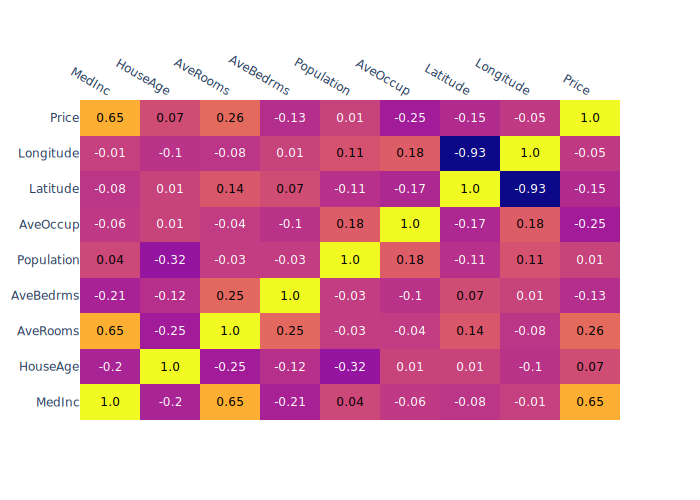

In [8]:
# Correlation matrix
corr_matrix = dataset.corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

The correlation between the median income and the target is quite high ! This is a good news, it suggests that we might be able to predict the values of the price with a good precision if we include this variable in the model's features. Some other variables might be useful as well: _AveRooms_, _AveOccup_ and _Latitude_. In the following, we'll create a baseline model with only _MedInc_, and then compare the performances with the ones reached by using all the variables alltogether.

## Baseline model

8. For our baseline, we'll only use the _MedInc_ variable as an input feature. Create a variable X containing the values of this features, and a variable Y containing the values of the target.

In [9]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["MedInc"]
target_variable = "Price"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Price, dtype: float64

X :
   MedInc
0  8.3252
1  8.3014
2  7.2574
3  5.6431
4  3.8462


9. Make a train/test splitting (keep 80% of the dataset for model training).

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

10. What preprocessings are necessary here? Apply it to X_train and X_test

In [11]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 19398

Display of dataset: 


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Basics statistics: 


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000
mean,3.674497,28.496907,5.210648,1.066038,1442.172080,2.944640,35.637872,-119.567484,1.924128
std,1.563397,12.477953,1.168098,0.128846,1077.498768,0.766194,2.142960,2.004793,0.971784
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990
25%,2.525900,18.000000,4.407329,1.005413,805.000000,2.450413,33.930000,-121.770000,1.167000
50%,3.447800,29.000000,5.170038,1.047619,1185.500000,2.842105,34.260000,-118.490000,1.741000
75%,4.583175,37.000000,5.944617,1.096884,1752.000000,3.308127,37.720000,-118.000000,2.485000
max,15.000100,52.000000,9.979167,3.411111,13251.000000,9.954545,41.950000,-114.550000,4.991000



Percentage of missing values: 


MedInc        0.0
HouseAge      0.0
AveRooms      0.0
AveBedrms     0.0
Population    0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
Price         0.0
dtype: float64

**We have only numeric features with no missing values, so here the preprocessing is very simple: we just want to standardize all the columns!**

In [12]:
print("Preprocessing X_train...")
print(X_train.head())
print()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array

Preprocessing X_train...
       MedInc
15015  2.9624
2823   5.5261
2795   2.3250
1360   3.3661
12795  1.5600

...Done!
[[-0.45883376]
 [ 1.1903096 ]
 [-0.86885209]
 [-0.19914692]
 [-1.36095127]]


In [13]:
print("Preprocessing X_test...")
print(X_test.head())
print()
X_test = scaler.transform(X_test) # don't fit again !
print("...Done!")
print(X_test[0:5,:]) # X_train is now a numpy array

Preprocessing X_test...
       MedInc
13065  4.5766
2516   3.0469
12039  3.3187
17668  3.2806
2426   2.2206

...Done!
[[ 0.57952767]
 [-0.40447771]
 [-0.22963777]
 [-0.25414624]
 [-0.93600915]]


11. Train the baseline model and print out its R2-score on train set and test set

In [14]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [15]:
# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

R2 score on training set :  0.4167165274921717
R2 score on test set :  0.4344122018672748


12. Plot the model's predictions

In [16]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[1.63713472 2.66860053 1.3806865  ... 2.85926701 2.19919649 2.15405452]



In [17]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[2.28658361 1.67113202 1.78048663 ... 2.46039226 2.85926701 1.45829689]



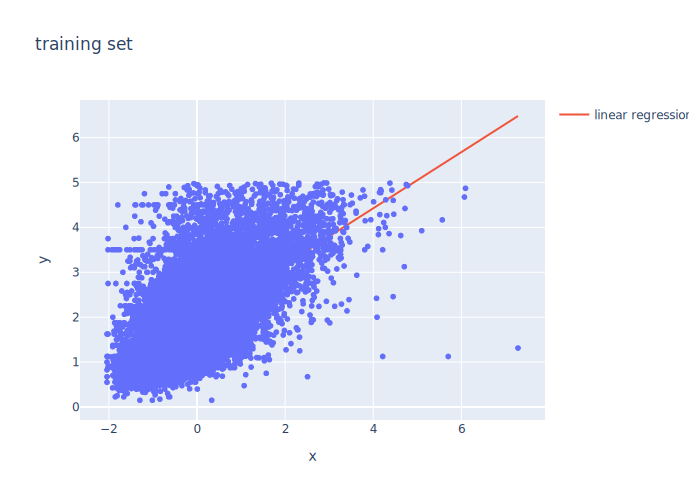

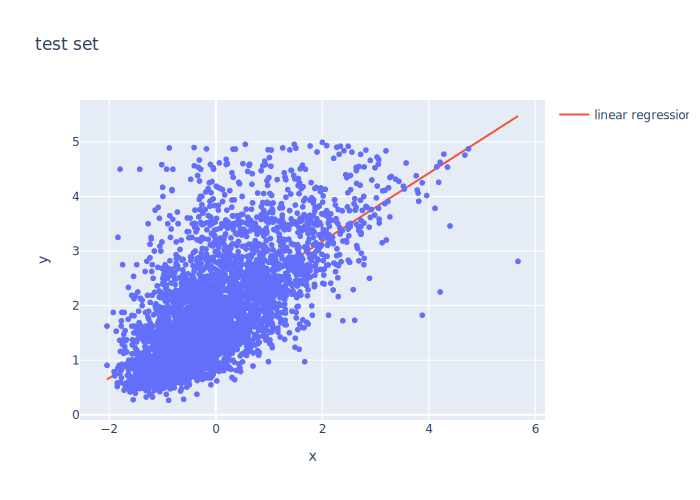

In [18]:
# Visualize the model
# Visualize predictions on training Set
fig = px.scatter(x = X_train.flatten().tolist(), y = Y_train, title = "training set")
fig.add_trace(go.Scatter(x = X_train.flatten().tolist(), y = Y_train_pred, name = "linear regression"))
fig.show()

# Visualize predictions on test Set
fig = px.scatter(x = X_test.flatten().tolist(), y = Y_test, title = "test set")
fig.add_trace(go.Scatter(x = X_test.flatten().tolist(), y = Y_test_pred, name = "linear regression"))
fig.show()

## Multivariate model
Our baseline is already performing way better than a "dummy" model, but let's see if you can improve the score by including all the explanatory variables in our model.

13. Train a multivariate model by including all the features

In [19]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Price"

X = dataset.drop(target_variable, axis = 1)
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
X.head()

Separating labels from features...
...Done.

Y : 
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Price, dtype: float64

X :


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [20]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [21]:
# Preprocessing
print("Preprocessing X_train...")
print(X_train.head())
print()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array

Preprocessing X_train...
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
3235   2.3889       6.0  6.316614   1.294671       992.0  3.109718     36.09   
13981  3.4912       7.0  8.355308   1.554795      2933.0  2.511130     34.85   
9219   1.9464      36.0  4.975510   1.053061       639.0  2.608163     37.12   
10851  3.1667      22.0  3.803838   1.000000      1952.0  2.081023     33.66   
8888   4.2520      31.0  3.978296   1.039389      1985.0  1.595659     34.03   

       Longitude  
3235     -119.57  
13981    -117.46  
9219     -120.27  
10851    -117.90  
8888     -118.49  

...Done!
[[-8.19927084e-01 -1.80892400e+00  9.55328430e-01  1.78190047e+00
  -4.16134941e-01  2.18006083e-01  2.11764744e-01 -2.73283112e-03]
 [-1.12594285e-01 -1.72879039e+00  2.70646520e+00  3.80387675e+00
   1.40114366e+00 -5.61637519e-01 -3.67622089e-01  1.05246805e+00]
 [-1.10387407e+00  5.95084207e-01 -1.96613519e-01 -9.61635976e-02
  -7.46634346e-01 -4.35254612e-01  6.9

In [22]:
print("Preprocessing X_test...")
print(X_test.head())
print()
X_test = scaler.transform(X_test) # don't fit again !
print("...Done!")
print(X_test[0:5,:]) # X_train is now a numpy array

Preprocessing X_test...
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
17333  5.2990      12.0  7.214932   1.047511      1200.0  2.714932     34.91   
1012   2.6667      44.0  4.541284   1.027523       277.0  2.541284     37.68   
5124   1.5521      30.0  3.850679   1.002262      1966.0  4.447964     33.99   
1845   6.3538      49.0  6.293886   1.017751      1148.0  2.264300     37.90   
4035   3.2154      20.0  4.133444   1.060181      7450.0  1.772122     34.17   

       Longitude  
17333    -120.44  
1012     -121.77  
5124     -118.26  
1845     -122.28  
4035     -118.52  

...Done!
[[ 1.04744947 -1.32812236  1.72693875 -0.13930381 -0.22139308 -0.29619119
  -0.33958724 -0.43781566]
 [-0.64166613  1.23615306 -0.56959193 -0.29467615 -1.08556008 -0.52236244
   0.95468818 -1.10294228]
 [-1.35689169  0.11428257 -1.16278792 -0.49102935  0.49578127  1.96103359
  -0.76945489  0.65239189]
 [ 1.72430209  1.6368211   0.9358055  -0.37063099 -0.27007855 -0.883

In [23]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [24]:
# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

R2 score on training set :  0.6270641950558857
R2 score on test set :  0.6357478886974353


Adding more variables in our model significantly improved the R2-score 🥳

## Feature importance

Let's analyze what features are important for the prediction.

14. Extract the model's coefficients and conclude about the important features

In [25]:
# As we didn't implement a complex preprocessing pipeline, the column names is just the initial list of features !
column_names = [c for c in dataset.columns if c != target_variable]

# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
MedInc,0.675650
HouseAge,0.117918
AveRooms,-0.138904
AveBedrms,0.112168
Population,0.043858
AveOccup,-0.209342
Latitude,-0.849220
Longitude,-0.792648


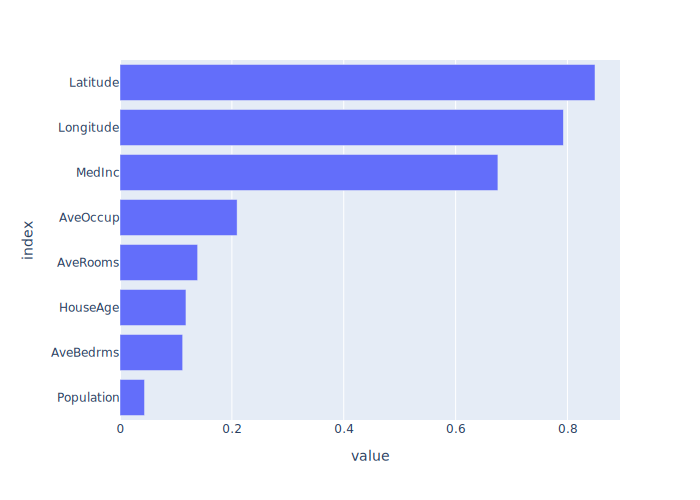

In [26]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

**Conclusion : the most important features are Latitude, Longitude, MedInc and AveOccup. It's interesting to notice that the model doesn't necessarily rank the features according to the values of the correlation coefficients. The reason why is that the correlation coefficient probes the linear relationship between the target and ONE feature at a time, whereas the model looks for the best COMBINATION of features.**